# Transformation data from the plate reader

This first part focuses in the transformation of the dataframe obtained from the plate reader

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import openpyxl
import statistics
import time
from statistics import mean
from pandas import read_csv
from scipy.optimize import curve_fit
from matplotlib import pyplot
from scipy import *
from numpy import inf
import math
from scipy import optimize


import xlsxwriter

# Para no mostrar 'Future Warnings' producto de que algunos paquetes aún
# trabajan con versiones no actualizadas de otros paquetes
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
data = pd.read_excel ('nameOfTheExcel.xlsx')
data[:10]

In [ ]:
df=data.transpose()
df

In [ ]:
nombres = [''+str(df.loc['Cycle Nr.'][i]) for i in range(98)] #Los nombres de las columnas están en la fila 'Cycle Nr.' (así lee python el fichero del excel del plate reader)
df.columns = nombres
YASI=df.drop('Cycle Nr.')
YASI

# Visualization of the data

This code uses the transformed data from the dataframe (=*YASI*) and creates a collection of dataframes. These dataframes are organized the same way as the real 96-well plate --> 8 rows x 12 columns

In [ ]:
dataframe_collection = {} 
   

wpdf=YASI.drop(['Time [s]','Temp. [°C]'],axis=1)
#wpdf tiene como primeros indices [1][0]
wellpl1 = pd.DataFrame(0.0, index=np.arange(12),columns=['A','B','C','D','E','F','G','H']) #Creo dataframevacio
wellplate=wellpl1.drop(0) #Formateo adecuadamente el dataframe vacío
wellplate.loc[12]=0
#wellplate tiene también como primeros indices [1][0]

# t = TIEMPO EN EL QUE SE QUIERE VER EL HEATMAP DE LA PLACA DE 96 POCILLOS
t=1
i=0
j=0
k=0
for t in range(len(wpdf -1)):
    for j in range(8):
        for k in range(12):
            wellplate.loc[k+1][j] = wpdf.loc[t+1][i]
            i=i+1
            k=k+1
        j=j+1
        k=1
        if(j==9):
            break
    #df3=pd.DataFrame(wellplate)
    df3=wellplate.copy()
    dataframe_collection[t+1] = df3
    j=0
    i=0
    t=t+1
    


### Heatmap of the dataframe collection


The following code shows the evolution of the dataframes in time as a heatmap --> it basically shows how the real 96-well plate evolves in time 

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import clear_output

plt.figure()
for i in range(len(dataframe_collection)):
    plt.imshow(dataframe_collection[i+1].transpose(), cmap='magma',vmax=1.4)
    plt.xticks(np.arange(0, len(wellplate.index), 1), wellplate.index)
    plt.yticks(np.arange(0, len(wellplate.columns), 1), wellplate.columns)
    plt.title('OD - Cycle %d' %(i+1))
    plt.colorbar()
    plt.show()
    clear_output(wait=True)

# Analysis

The analysis focuses in processing the data of each growth curve. The curves need to be normalized an indexed by their names and cycle.

In [2]:
#The curves need to be indexed by their names and the cycle
data = pd.read_excel ('nameOfTheExcelWithTheCurves.xlsx')

In [3]:
col=np.arange(len(data.columns))
data.columns=col
data

,0,1,2,3,4,5,6,7,8,9,...,276,277,278,279,280,281,282,283,284,285
LB,0.008475,0.002825,0.00295,0.003425,0.004125,0.00470,0.00605,0.00730,0.00905,0.011375,...,0.842125,0.839825,0.840025,0.839075,0.83815,0.83855,0.83690,0.837175,0.83535,0.83535
CFSwt(Co),0.002150,0.001550,0.00175,0.002100,0.002700,0.00345,0.00420,0.00530,0.00645,0.007900,...,0.571300,0.572650,0.570650,0.570850,0.57010,0.56840,0.56895,0.570400,0.56950,0.56800
CFSwt(Co/2),-0.003250,0.001350,0.00165,0.002050,0.002650,0.00345,0.00435,0.00555,0.00695,0.008650,...,0.679150,0.677900,0.678200,0.677100,0.67645,0.67605,0.67530,0.673600,0.67405,0.67485
CFSwt(Co/4),-0.004400,0.002550,0.00300,0.003450,0.004100,0.00485,0.00590,0.00705,0.00850,0.010400,...,0.828950,0.827050,0.827550,0.827350,0.82690,0.82665,0.82600,0.824650,0.82435,0.82420
CFSwt(Co/8),0.000300,0.002550,0.00265,0.003050,0.003650,0.00455,0.00520,0.00705,0.00800,0.010150,...,0.825600,0.825100,0.823800,0.823300,0.82230,0.82190,0.82165,0.820150,0.82000,0.81965
CFSwt(Co/16),0.012350,0.001400,0.00190,0.002250,0.002800,0.00355,0.00470,0.00595,0.00755,0.009550,...,0.854300,0.853600,0.852600,0.852500,0.85175,0.85060,0.85165,0.849850,0.84855,0.84850
CFSpksj331(Co),-0.005700,0.001750,0.00190,0.002100,0.002300,0.00255,0.00285,0.00330,0.00380,0.004550,...,0.633100,0.631850,0.631400,0.630850,0.63035,0.63045,0.62925,0.629300,0.62810,0.62830
CFSpksj331(Co/2),-0.007450,0.001750,0.00185,0.002100,0.002400,0.00280,0.00335,0.00400,0.00485,0.006000,...,0.729000,0.728700,0.728450,0.728300,0.72790,0.72720,0.72775,0.728950,0.72775,0.72715
CFSpksj331(Co/4),-0.005900,0.002650,0.00280,0.003050,0.003750,0.00325,0.00380,0.00470,0.00580,0.007100,...,0.815200,0.814600,0.814950,0.815100,0.81425,0.81350,0.81315,0.812800,0.81110,0.81040
CFSpksj331(Co/8),-0.006000,0.002150,0.00235,0.002700,0.003100,0.00360,0.00435,0.00535,0.00660,0.008150,...,0.842500,0.841500,0.840050,0.839650,0.83830,0.83780,0.83720,0.836900,0.83770,0.83705


### Basic functions
- **values(name)** --> returns the maximum value and the difference between the maximum and final values of a curve. The output is a 1x2 array.
<br/>

- **line(x,a,b)** --> equation for the line of the maximum growth.
$$y = a m + b$$
- **filt** --> filter for a given curve: it applies a size-3-window median filter, for reducing the high-amplitude noise; after, the curve is filtered with a size-3-window mean filter to obtain smoother values.
<br/>
<br/>

For the R^2:

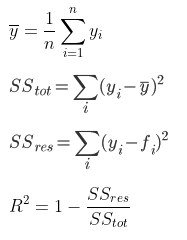 

<br/>
where  $$SS_{tot}$$ is the "total sum of squares" and quantifies how much the data points, yi, vary around their mean, y¯;<br/>
<br/>
$$SS_{res}$$ is the "error sum of squares" and quantifies how much the data points, yi, vary around the estimated regression line, fi.<br/>
<br/>




**Bibliography:**


https://machinelearningmastery.com/curve-fitting-with-python/<br/>
https://online.stat.psu.edu/stat462/node/95/<br/>
https://stackoverflow.com/questions/19189362/getting-the-r-squared-value-using-curve-fit

Enders, Felicity Boyd. "Coefficient of determination". Encyclopedia Britannica, 26 May. 2020, <br/>
https://www.britannica.com/science/coefficient-of-determination <br/>
<br/>

For the filtering:<br/>
https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-016-1134-2#:~:text=PRECOG%20is%20a%20tool%20that,vast%20and%20informative%20phenomics%20databases.<br/>

In [4]:
def values(name):
    a = []
    i = 0
    j = 0
    #Add max value of a curve to vector 'a'
    a.append(max(data.loc[name]))
    #Search cycle of that max value and add it to 'a'
    for i in range(len(data.loc[name])):
        if(max(data.loc[name]) == data.loc[name][i]):
            j = i
            a.append(j)
    #Final value of a curve
    a.append(data.loc[name][len(data.columns)-1])
    #Max value - Final value
    a.append(max(data.loc[name])-data.loc[name][len(data.columns)-1])
    return a

In [5]:
#Function for the line of the maximum growth
def line(x, a_prov, b_prov):
        return a_prov * x + b_prov

In [6]:
def filt(array):
    cont=1
    newArray = array
    
    ## Median of the array. It reduces high frequency noise
    while cont <= (len(array)-2):
        newArray[cont] = statistics.median([array[cont-1],array[cont],array[cont+1]])
        cont = cont+1
    cont = 1
    
    ## Smoothing filter: mean with a 3-size window. It reduces low frequency noise.
    newArray2 = newArray
    while cont <= (len(array)-2):
        newArray2[cont] = (newArray[cont-1]+newArray[cont+1])/2
        cont = cont+1
    
    return newArray2   

## Fit a curve to the bacterian growth

### Gompertz fit:
To analyze the growth curve of bacteria, a Gompertzian is fitted into the data points obtained from the plate reader:

- **gompertz** --> definition of the Gompertz equation:
$$f_{gompertz}(t) = ae^{-be^{-ct}}$$
<br/>
- **gompertzValues(curve)** --> this function returns an array with the values of the curve that better adjusts to the dataframe obtained from the plate reader
    - gompertzValues[0] = a
    - gompertzValues[1] = b
    - gompertzValues[2] = c
    - gompertzValues[3] = R^2 of the adjustment 
    
<br/>

- **plotGompertz(curve)** --> this function receives that same dataframe and it plots the curve that better adjusts to this values.
<br/>


In [7]:
def gompertz(x,a,b,c):
      #a = asymptote of the curve
      #b = x axis displacement
      #c = growth rate
    return a*(math.e**((-b)*(math.e**((-c)*x))))

In [8]:
def gompertzValues(name):
    x = np.array(data.columns)
    y1 = np.array(data.loc[name])
    y = pd.DataFrame(y1)
    y=y[0]
    y[y < 0] = 0.000000001 #if there are any negative values, we make them 0. If not, the log2 won't work
    y[y == 0] = 0.000000001
    y = filt(y)
    i=0
    while i<len(data.columns):
        if y[i] == max(y):
            YY = y[:i]
            XX = np.arange(i)
        i = i+1
    
    popt, pcov = curve_fit(gompertz, XX, YY)
    
    #We calculate R^2 for the fit
    residuals = YY - gompertz(XX, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((YY-np.mean(YY))**2)
    r2_prov = 1 - (ss_res / ss_tot)
    
    print('Value of R^2 = '+str(r2_prov))
    return [*popt,r2_prov]

In [9]:
def plotGompertz(name):
    x = np.array(data.columns)
    y1 = np.array(data.loc[name])
    y = pd.DataFrame(y1)
    y=y[0]
    y[y < 0] = 0.000000001 #if there are any negative values, we make them 0. If not, the log2 won't work
    y[y == 0] = 0.000000001
    y = filt(y)
    
    i=0
    while i<len(data.columns):
        if y[i] == max(y):
            YY = y[:i]
            XX = np.arange(i)
        i = i+1
    
    popt, pcov = curve_fit(gompertz, XX, YY)

    f_gom = gompertz(XX, popt[0], popt[1], popt[2])
    plt.plot(XX,YY, label=name)
    plt.plot(XX,f_gom, label="Gompertz fit")
    plt.title('OD of '+name)
    plt.xlabel('Cycle', color='#1C2833')
    plt.ylabel('OD600', color='#1C2833')
    plt.legend(loc='lower right')
    plt.show()

### Logistic fit

$$\frac{dP}{dt} = rP(1-\frac{P}{K})$$

$$P_{log}(t) = \frac{P_{0}Ke^{rt}}{K-P_{0}+P_{0}e^{rt}}$$

<br/>

Where:
- **P0** = initial population
- **K** = carrying capacity --> maximum population of that organism that the environment can sustain indefinitely
- **r** = growth rate

In [22]:
def logistic(x,P0,K,r):

    return P0*K*np.exp(r*x)/((K-P0)+P0*np.exp(r*x))

In [23]:
def logisticValues(name):
    
    x = np.array(data.columns)
    y1 = np.array(data.loc[name])
    y = pd.DataFrame(y1)
    y=y[0]
    y[y < 0] = 0.000000001 #if there are any negative values, we make them 0. If not, the log2 won't work
    y[y == 0] = 0.000000001
    y = filt(y)

    i=0
    while i<len(data.columns):
        if y[i] == max(y):
            YY = y[:i]
            XX = np.arange(i)
        i = i+1
    
    popt, pcov = curve_fit(logistic, XX, YY, p0 = [0.09, 1.2, 0.1])
    
    #We calculate R^2 for the fit
    residuals = YY - logistic(XX, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((YY-np.mean(YY))**2)
    r2_prov = 1 - (ss_res / ss_tot)
    
    print('Value of R^2 = '+str(r2_prov))
    return [*popt,r2_prov]

In [24]:
def plotLogistic(name):
    
    x = np.array(data.columns)
    y1 = np.array(data.loc[name])
    y = pd.DataFrame(y1)
    y=y[0]
    y[y < 0] = 0.000000001 #if there are any negative values, we make them 0. If not, the log2 won't work
    y[y == 0] = 0.000000001
    y = filt(y)
    
    i=0
    while i<len(data.columns):
        if y[i] == max(y):
            YY = y[:i]
            XX = np.arange(i)
        i = i+1
    

    popt, pcov = curve_fit(logistic, XX, YY, p0 = [0.09, 1.2, 0.1])

    f_gom = logistic(XX, popt[0], popt[1], popt[2])
    plt.plot(XX,YY, label = name)
    plt.plot(XX,f_gom, label="Logistic fit")
    plt.title('OD of '+name)
    plt.xlabel('Cycle', color='#1C2833')
    plt.ylabel('OD600', color='#1C2833')
    plt.legend(loc='lower right')
    plt.show()

## Regression slope

Some functions have been implemented for the analysis of the curves previously selected from our Excel datasets. The following funtions are available:<br/>

- **growthRateValues(name)** --> this function receives the curve (transforms it into log2) to analyze and returns an *array[1x7]*  with the coefficients of the line that better adjusts to the maximum growth of the curve. This maximum growth is calculated using the *curve_fit* method, and only a mamimum growth adjusted with an R2 > 0.99 is taken into account. The returned *array* has the following structure:
    * *array[0]* = cycle for the maximun growth
    * *array[1]* = time for the maximun growth
    * *array[2]* = R2 of the regression line calculated for the maximun growth
    * *array[3]* = slope of the regresion line
    * *array[4]* = origin ordinate of the regression line
    * *array[5]* = maximum value of the original curve
    * *array[6]* = difference between the maximun value of the original curve an the last datapoint for this curve

[cycle, t, r2, a, b, values(name)[0],values(name)[1]]

- **growthRate(name)** --> plots the maximum growth rate for a given curve (transforming it into log2).
<br/>

- **allGrowthRateNoFilter(name)** --> scatters all growth rate values for a given curve (transforming it into log2).
<br/>

- **allGrowthRateWithFilter(name)** --> scatters all growth rate values for a given curve (transforming it into log2) after having filtered it.
<br/>

<br/>

Functions without log2:
- **slope(name)** --> finds the maximum slope for a given curve, after having filtered it.
<br/>

- **allSlopes(name)** --> plots all slopes of a given curve, after having filtered it.


### Bibliography
<br/>

For the growth rate:<br/>
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2992018/<br/>
https://realpython.com/linear-regression-in-python/<br/>


In [13]:
def growthRateValues(name):

    y1 = np.array(data.loc[name])
    y = pd.DataFrame(y1)
    y=y[0]
    y[y < 0] = 0.000000001 #if there are any negative values, we make them 0. If not, the log2 won't work
    y[y == 0] = 0.000000001
    y = filt(y)
    x_total, y_total = data.columns, np.log2(y)  #save in x_total the names of the columns of data and in y_total the values for a specific curve

    a = 0
    b= 0
    cycle = 0
    r2=0
    cont = 4 #We start in the cycle 1
    subs = 5  #we are taking values from [x-5:x+5]
    
    while cont <= (len(data.columns)):
        if(cont<subs):
            x_prov = x_total[0:cont+subs+1]  #Each cycle of the while we define the values of the x (x_prov) and y (y_prov) that we are interested in
            y_prov = y_total[0:cont+subs+1]  #We put the +1 because the final value of the index is not included 
        else:
            x_prov = x_total[cont-subs:cont+subs+1]  #Each cycle of the while we define the values of the x (x_prov) and y (y_prov) that we are interested in
            y_prov = y_total[cont-subs:cont+subs+1]  #We put the +1 because the final value of the index is not included
        
        #valid = ~(np.isnan(x_prov) | np.isnan(y_prov))  
        #We check that neither x_prov or y_prov have NaN values (because it would cause an error)
        x_prov = x_prov.fillna(0)
        y_prov = y_prov.fillna(0)
        popt, _ = curve_fit(line, x_prov, y_prov) #Using curve_fit we obtain the values for the slope and origin ordinate of the trendline, in the form of a vector [popt]
        a_prov, b_prov = popt  #a_prov --> slope     b_prov --> origin ordinate
        
        residuals = y_prov - line(x_prov, *popt) #We calculate R^2 for that trendline
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y_prov-np.mean(y_prov))**2)
        r2_prov = 1 - (ss_res / ss_tot)
        
        if (r2_prov>=0.99) and (a_prov>a):
            a=a_prov
            b=b_prov
            x = x_prov  #No se si sirve
            y = y_prov  #No se si sirve
            cycle = cont
            r2=r2_prov
        cont = cont+1
    
    t=round(cycle/6,3)
    output = [cycle, t, r2, a, b, values(name)[0],(values(name)[1])/6,values(name)[2], values(name)[3]]
    
    return output

In [15]:
def growthRate(name):
    

    y1 = np.array(data.loc[name])
    y = pd.DataFrame(y1)
    y=y[0]
    y[y < 0] = 0.000000001 #if there are any negative values, we make them 0. If not, the log2 won't work
    y[y == 0] = 0.000000001
    y = filt(y)
    x_total, y_total = data.columns, np.log2(y)  #save in x_total the names of the columns of data and in y_total the values for a specific curve
    #y_total = filt(y_total)
    
    a = 0
    b= 0
    cycle = 0
    r2=0
    cont = 4 #We start in the cycle 1
    subs = 5  #we are taking values from [x-5:x+5]
    
    while cont <= (len(data.columns)):
        if(cont<subs):
            x_prov = x_total[0:cont+subs+1]  #Each cycle of the while we define the values of the x (x_prov) and y (y_prov) that we are interested in
            y_prov = y_total[0:cont+subs+1]  #We put the +1 because the final value of the index is not included 
        else:
            x_prov = x_total[cont-subs:cont+subs+1]  #Each cycle of the while we define the values of the x (x_prov) and y (y_prov) that we are interested in
            y_prov = y_total[cont-subs:cont+subs+1]  #We put the +1 because the final value of the index is not included
        
        #valid = ~(np.isnan(x_prov) | np.isnan(y_prov))  #We check that neither x_prov or y_prov have NaN values (because it would cause an error)
        x_prov = x_prov.fillna(0)
        y_prov = y_prov.fillna(0)
        popt, _ = curve_fit(line, x_prov, y_prov) #Using curve_fit we obtain the values for the slope and origin ordinate of the trendline, in the form of a vector [popt]
        a_prov, b_prov = popt  #a_prov --> slope     b_prov --> origin ordinate
        
        residuals = y_prov - line(x_prov, *popt) #We calculate R^2 for that trendline
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y_prov-np.mean(y_prov))**2)
        r2_prov = 1 - (ss_res / ss_tot)
        
        if (r2_prov>=0.99) and (a_prov>a):
            a=a_prov
            b=b_prov
            x = x_prov  #No se si sirve
            y = y_prov  #No se si sirve
            cycle = cont
            r2=r2_prov
        cont = cont+1
    
    #PLOTING
    # seting the axis
    axes = plt.gca()
    axes.set_ylim([-20,0.5])
    # plot the curve
    plt.plot(y_total, label='log2(curve)')
    # ploting the discotinuos line
    x_line = arange(min(x_total), max(x_total), 1)
    y_line = line(x_line, a, b)
    pyplot.plot(x_line, y_line, '--', color='red', label = 'Max growth rate')
    # black dot (cycle for the maximun)
    xCruce=cycle
    yCruce=np.log2(data.loc[name])[cycle]
    plt.plot(xCruce,yCruce,marker='o', color='k')
    
    plt.title('Max growth rate for '+name)
    plt.xlabel('Cycle', color='#1C2833')
    plt.ylabel('log2(OD600)', color='#1C2833')
    plt.legend(loc='upper left')
    plt.grid()
    pyplot.show()
    
    t=round(cycle/3600,3)
    print('Equation for the maximun growth rate:')
    print("\x1b[31m y = %.5f * x + %.5f\x1b[0m" % (a, b))
    print('Cycle:'+str(cycle)+' || Time='+str(t)+'h')
    
    y.update(data.loc[name])

## Saving data in an excel file
The following code focuses in saving the data obtained in the previous functions<br/>
<br/>

In [34]:
#Saving Maximum value and growth rate of each curve

import xlsxwriter

wb = xlsxwriter.Workbook('Analysis values (python).xlsx')
ws = wb.add_worksheet('my sheet')

# write the header in row 0, which is Excel row 1
# for write_columns the (1,0,_) writes in the second row-first column
ws.write_column(1,0,data.index)
ws.write_row(0,1,['Cycle Max growth rate', 't', 'r^2', 'Growth rate', 'Origin ordinate', 'Max value', 'Time Max value','Final value','Max value - Final value'])
i=0
for i in range(len(data.index)):
    ws.write_row(i+1, 1, growthRateValues(data.index[i]))

wb.close()

C:\Users\jaime\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in double_scalars


In [36]:
i

50

In [ ]:
wb = xlsxwriter.Workbook('Analisis fits (Gompertz & Logistic) (python).xlsx')

#Gompertz worksheet
ws1 = wb.add_worksheet('Gompertz')
# write the header in row 0, which is Excel row 1
# for write_columns the (1,0,_) writes in the second row-first column
ws1.write_column(1,0,data.index)
ws1.write_row(0,1,['Asymptote (Gompertz)','x axis displacement (Gompertz)', 'Growth rate (Gompertz)', 'R^2'])
i=0
for i in range(len(data.index)):
    ws1.write_row(i+1, 1, gompertzValues(data.index[i]))


#Logistic worksheet
ws2 = wb.add_worksheet('Logistic')
ws2.write_column(1,0,data.index)
ws2.write_row(0,1,['Initial population (Logistic)', 'Carying capacity (Logistic)', 'Growth rate (Logistic)', 'R^2'])
i=0
for i in range(len(data.index)):
    ws2.write_row(i+1, 1, logisticValues(data.index[i]))
    
wb.close()

In [ ]:
i

<br/>

### All growth rates
<br/>
Now we represent all growth rates for a given curve, with and without any filtering, in a scatter plot. 

In [17]:
from scipy import optimize
from numpy import inf

def allGrowthRateNoFilter(name):

    y1 = np.array(data.loc[name])
    y = pd.DataFrame(y1)
    y=y[0]
    y[y < 0] = 0.000000001 #if there are any negative values, we make them 0. If not, the log2 won't work
    y[y == 0] = 0.000000001
    #y = filt(y)
    x_total, y_total = data.columns, np.log2(y)  #save in x_total the names of the columns of data and in y_total the values for a specific curve
    #y_total = filt(y_total)
    a = []
    cont = 1 #We start in the cycle 1
    subs = 5  #we are taking values from [x-5:x+5]
    
    while cont <= (len(data.columns)):
        if(cont<subs):
            x_prov = x_total[0:cont+subs+1]  #Each cycle of the while we define the values of the x (x_prov) and y (y_prov) that we are interested in
            y_prov = y_total[0:cont+subs+1]  #We put the +1 because the final value of the index is not included 
        else:
            x_prov = x_total[cont-subs:cont+subs+1]  #Each cycle of the while we define the values of the x (x_prov) and y (y_prov) that we are interested in
            y_prov = y_total[cont-subs:cont+subs+1]  #We put the +1 because the final value of the index is not included
        
        y_prov = y_prov.fillna(0)
        popt, _ = curve_fit(line, x_prov, y_prov) #Using curve_fit we obtain the values for the slope and origin ordinate of the trendline, in the form of a vector [popt]
        a_prov, b_prov = popt  #a_prov --> slope     b_prov --> origin ordinate
        a.append(a_prov)
        cont = cont+1
    
    plt.scatter(x_total,a)
        
    plt.title('Growth rate for '+name)
    plt.xlabel('Cycle', color='#1C2833')
    plt.ylabel('Growth rate (log2)', color='#1C2833')
    plt.legend(loc='upper left')
    #plt.grid()
    pyplot.show()
    #plt.show()

In [19]:
from scipy import optimize
from numpy import inf

def allGrowthRateWithFilter(name):

    y1 = np.array(data.loc[name])
    y = pd.DataFrame(y1)
    y=y[0]
    y[y < 0] = 0.000000001 #if there are any negative values, we make them 0. If not, the log2 won't work
    y[y == 0] = 0.000000001
    y = filt(y)
    x_total, y_total = data.columns, np.log2(y)  #save in x_total the names of the columns of data and in y_total the values for a specific curve
    #y_total = filt(y_total)
    a = []
    cont = 1 #We start in the cycle 1
    subs = 5  #we are taking values from [x-5:x+5]
    
    while cont <= (len(data.columns)):
        if(cont<subs):
            x_prov = x_total[0:cont+subs+1]  #Each cycle of the while we define the values of the x (x_prov) and y (y_prov) that we are interested in
            y_prov = y_total[0:cont+subs+1]  #We put the +1 because the final value of the index is not included 
        else:
            x_prov = x_total[cont-subs:cont+subs+1]  #Each cycle of the while we define the values of the x (x_prov) and y (y_prov) that we are interested in
            y_prov = y_total[cont-subs:cont+subs+1]  #We put the +1 because the final value of the index is not included
        
        y_prov = y_prov.fillna(0)
        popt, _ = curve_fit(line, x_prov, y_prov) #Using curve_fit we obtain the values for the slope and origin ordinate of the trendline, in the form of a vector [popt]
        a_prov, b_prov = popt  #a_prov --> slope     b_prov --> origin ordinate
        a.append(a_prov)
        cont = cont+1
    
    #plt.title(name)
    # plot the growth rates
    
    figure, axis_1 = plt.subplots()
    axis_1.title.set_text(name)
    axis_1.scatter(x_total, a, color='b', label='Growth rate')
    axis_1.set_ylabel('Growth rate (log2)')
    axis_1.set_xlabel('Cycle')
    
    # plot the log2 of the growth curve
    axis_2 = axis_1.twinx()
    axis_2.plot(x_total, y_total, color='k', label='log2')
    axis_2.set_ylabel('log2(OD600)')
    
    lines_1, labels_1 = axis_1.get_legend_handles_labels()
    lines_2, labels_2 = axis_2.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    axis_1.legend(lines, labels, loc='lower right')
    
    print('Maximum growth rate (with r2 >= 0.99): '+str(growthRateValues(name)[3]))
    print('Cycle: '+str(str(growthRateValues(name)[0])))


### slope function

In [21]:
def slope(name):
    

    y1 = np.array(data.loc[name])
    y = pd.DataFrame(y1)
    y=y[0]
    y[y < 0] = 0.000000001 #if there are any negative values, we make them 0. If not, the log2 won't work
    y[y == 0] = 0.000000001
    y_total = filt(y)
    x_total = data.columns  #save in x_total the names of the columns of data and in y_total the values for a specific curve
    #y_total = filt(y_total)
    
    a = 0
    b= 0
    cycle = 0
    r2=0
    cont = 4 #We start in the cycle 1
    subs = 5  #we are taking values from [x-5:x+5]
    
    while cont <= (len(data.columns)):
        if(cont<subs):
            x_prov = x_total[0:cont+subs+1]  #Each cycle of the while we define the values of the x (x_prov) and y (y_prov) that we are interested in
            y_prov = y_total[0:cont+subs+1]  #We put the +1 because the final value of the index is not included 
        else:
            x_prov = x_total[cont-subs:cont+subs+1]  #Each cycle of the while we define the values of the x (x_prov) and y (y_prov) that we are interested in
            y_prov = y_total[cont-subs:cont+subs+1]  #We put the +1 because the final value of the index is not included
        
        #valid = ~(np.isnan(x_prov) | np.isnan(y_prov))  #We check that neither x_prov or y_prov have NaN values (because it would cause an error)
        x_prov = x_prov.fillna(0)
        y_prov = y_prov.fillna(0)
        popt, _ = curve_fit(line, x_prov, y_prov) #Using curve_fit we obtain the values for the slope and origin ordinate of the trendline, in the form of a vector [popt]
        a_prov, b_prov = popt  #a_prov --> slope     b_prov --> origin ordinate
        
        residuals = y_prov - line(x_prov, *popt) #We calculate R^2 for that trendline
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y_prov-np.mean(y_prov))**2)
        r2_prov = 1 - (ss_res / ss_tot)
        
        if (r2_prov>=0.99) and (a_prov>a):
            a=a_prov
            b=b_prov
            x = x_prov  #No se si sirve
            y = y_prov  #No se si sirve
            cycle = cont
            r2=r2_prov
        cont = cont+1
    
    #PLOTING
    # seting the axis
    axes = plt.gca()
    axes.set_ylim([-0.05,1.2])
    # plot the curve
    plt.plot(y_total, label='OD600')
    # ploting the discotinuos line
    x_line = arange(min(x_total), max(x_total), 1)
    y_line = line(x_line, a, b)
    pyplot.plot(x_line, y_line, '--', color='red', label = 'Max slope')
    # black dot (cycle for the maximun)
    xCruce=cycle
    yCruce=y_total[cycle]
    plt.plot(xCruce,yCruce,marker='o', color='k')
    
    plt.title('Max slope for '+name)
    plt.xlabel('Cycle', color='#1C2833')
    plt.ylabel('OD600', color='#1C2833')
    plt.legend(loc='upper left')
    plt.grid()
    pyplot.show()
    
    t=round(cycle/3600,3)
    print('Equation for the maximun slope:')
    print("\x1b[31m y = %.5f * x + %.5f\x1b[0m" % (a, b))
    print('Cycle:'+str(cycle)+' || Time='+str(t)+'h')
    
    y.update(data.loc[name])

In [23]:
def allSlopes(name):

    y1 = np.array(data.loc[name])
    y = pd.DataFrame(y1)
    y=y[0]
    y[y < 0] = 0.000000001 #if there are any negative values, we make them 0. If not, the log2 won't work
    y[y == 0] = 0.000000001
    y_total = filt(y)
    x_total = data.columns  #save in x_total the names of the columns of data and in y_total the values for a specific curve
    #y_total = filt(y_total)
    a = []
    cont = 1 #We start in the cycle 1
    subs = 5  #we are taking values from [x-5:x+5]
    
    while cont <= (len(data.columns)):
        if(cont<subs):
            x_prov = x_total[0:cont+subs+1]  #Each cycle of the while we define the values of the x (x_prov) and y (y_prov) that we are interested in
            y_prov = y_total[0:cont+subs+1]  #We put the +1 because the final value of the index is not included 
        else:
            x_prov = x_total[cont-subs:cont+subs+1]  #Each cycle of the while we define the values of the x (x_prov) and y (y_prov) that we are interested in
            y_prov = y_total[cont-subs:cont+subs+1]  #We put the +1 because the final value of the index is not included
        
        y_prov = y_prov.fillna(0)
        popt, _ = curve_fit(line, x_prov, y_prov) #Using curve_fit we obtain the values for the slope and origin ordinate of the trendline, in the form of a vector [popt]
        a_prov, b_prov = popt  #a_prov --> slope     b_prov --> origin ordinate
        a.append(a_prov)
        cont = cont+1
    
    figure, axis_1 = plt.subplots()
    
    axis_1.set_ylim([-0.005,0.035])
    
    axis_1.title.set_text(name)
    axis_1.scatter(x_total, a, color='b', label='slope')
    axis_1.set_ylabel('slope')
    axis_1.set_xlabel('Cycle')
    
    # plot the log2 of the growth curve
    axis_2 = axis_1.twinx()
    axis_2.plot(x_total, y_total, color='k', label='OD600')
    axis_2.set_ylabel('OD600')
    
    lines_1, labels_1 = axis_1.get_legend_handles_labels()
    lines_2, labels_2 = axis_2.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    axis_1.legend(lines, labels, loc='lower right')
    
    i=0
    i_max = 0
    while i<len(data.columns):
        if a[i] == max(a):
            i_max = i
        i = i+1
    
    print('Maximum slope: '+str(max(a)))
    print('Cycle: '+str(i_max))


In [26]:
def slopeValues(name):
    

    y1 = np.array(data.loc[name])
    y = pd.DataFrame(y1)
    y=y[0]
    y[y < 0] = 0.000000001 #if there are any negative values, we make them 0. If not, the log2 won't work
    y[y == 0] = 0.000000001
    y_total = filt(y)
    x_total = data.columns  #save in x_total the names of the columns of data and in y_total the values for a specific curve
    #y_total = filt(y_total)
    
    a = 0
    b= 0
    cycle = 0
    r2=0
    cont = 4 #We start in the cycle 1
    subs = 5  #we are taking values from [x-5:x+5]
    
    while cont <= (len(data.columns)):
        if(cont<subs):
            x_prov = x_total[0:cont+subs+1]  #Each cycle of the while we define the values of the x (x_prov) and y (y_prov) that we are interested in
            y_prov = y_total[0:cont+subs+1]  #We put the +1 because the final value of the index is not included 
        else:
            x_prov = x_total[cont-subs:cont+subs+1]  #Each cycle of the while we define the values of the x (x_prov) and y (y_prov) that we are interested in
            y_prov = y_total[cont-subs:cont+subs+1]  #We put the +1 because the final value of the index is not included
        
        #valid = ~(np.isnan(x_prov) | np.isnan(y_prov))  #We check that neither x_prov or y_prov have NaN values (because it would cause an error)
        x_prov = x_prov.fillna(0)
        y_prov = y_prov.fillna(0)
        popt, _ = curve_fit(line, x_prov, y_prov) #Using curve_fit we obtain the values for the slope and origin ordinate of the trendline, in the form of a vector [popt]
        a_prov, b_prov = popt  #a_prov --> slope     b_prov --> origin ordinate
        
        residuals = y_prov - line(x_prov, *popt) #We calculate R^2 for that trendline
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y_prov-np.mean(y_prov))**2)
        r2_prov = 1 - (ss_res / ss_tot)
        
        if (r2_prov>=0.99) and (a_prov>a):
            a=a_prov
            b=b_prov
            x = x_prov  #No se si sirve
            y = y_prov  #No se si sirve
            cycle = cont
            r2=r2_prov
        cont = cont+1
    
    
    t=round(cycle/6,3)
    output = [cycle,t,a]
    
    return output

In [50]:
import xlsxwriter

wb = xlsxwriter.Workbook('Maximum slope.xlsx')
ws = wb.add_worksheet('my sheet')

# write the header in row 0, which is Excel row 1
# for write_columns the (1,0,_) writes in the second row-first column
ws.write_column(1,0,data.index)
ws.write_row(0,1,['cycle, t , slope'])
i=0
for i in range(len(data.index)):
    ws.write_row(i+1, 1, slopeValues(data.index[i]))
    #ws.write_row(i+1, 1, [data.loc[data.index[i]][slopeValues(data.index[i])[0]]]) --> for the OD max slope
wb.close()

In [27]:
def timeLag(name):
    
    y1 = np.array(data.loc[name])
    y = pd.DataFrame(y1)
    y=y[0]
    y[y < 0] = 0.000000001 #if there are any negative values, we make them 0. If not, the log2 won't work
    y[y == 0] = 0.000000001
    y_total = filt(y)
    x_total = data.columns  #save in x_total the names of the columns of data and in y_total the values for a specific curve
    #y_total = filt(y_total)
    
    OD = 0.2
    cont = 0
    lag = 0
    while cont < len(x_total):
        if y_total[cont] >= OD:
            lag = cont
            break
        if cont == len(x_total)-1:
            lag = cont
        cont = cont +1
            
    return cont

In [29]:
import xlsxwriter

wb = xlsxwriter.Workbook('Time Lag (OD = 0.2).xlsx')
ws = wb.add_worksheet('my sheet')

# write the header in row 0, which is Excel row 1
# for write_columns the (1,0,_) writes in the second row-first column
ws.write_column(1,0,data.index)
ws.write_row(0,1,['Time Lag'])
i=0
for i in range(len(data.index)):
    #ws.write_row(i+1, 1, slopeValues(data.index[i]))
    ws.write_row(i+1, 1, [timeLag(data.index[i])])
wb.close()